In [18]:
import nibabel as nib
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from skimage.transform import rotate
import random

In [19]:
# Função que carrega os dados com pares de imagens
def load_data_with_pairs(folder):
    if not os.path.exists(folder):
        print(f"A pasta {folder} não existe.")
        return {}, {}, {}, {}, {}

    images_by_group = {}
    mask_by_group = {}
    patient_ids = []

    # Itera sobre os pacientes no diretório
    for patient_id in tqdm(os.listdir(folder), desc="Carregamento de arquivos NIfTI..."):
        patient_path = os.path.join(folder, patient_id)

        areas_image = ["left", "right"]
        areas_mask = ["lesion_left", "lesion_right"]
        side_path_left = os.path.join(patient_path, areas_image[0])
        side_path_right = os.path.join(patient_path, areas_image[1])
        lesion_path_left = os.path.join(patient_path, areas_mask[0])
        lesion_path_right = os.path.join(patient_path, areas_mask[1])

        if patient_id not in images_by_group:
            images_by_group[patient_id] = {}
        if patient_id not in mask_by_group:
            mask_by_group[patient_id] = {}
        for type_image, type_mask in zip(areas_image, areas_mask):
            if type_image not in images_by_group[patient_id]:
                images_by_group[patient_id][type_image] = []
            if type_mask not in mask_by_group[patient_id]:
                mask_by_group[patient_id][type_mask] = []
            
            # Carrega as imagens e máscaras do lado esquerdo
            for patch_id, mask_id in zip(os.listdir(side_path_left), os.listdir(lesion_path_left)):
                img_path= os.path.join(side_path_left, patch_id)
                mask_path = os.path.join(lesion_path_left, mask_id)
                for img_path_left, mask_path_left in zip(os.listdir(img_path), os.listdir(mask_path)):
                    image_data_left = nib.load(os.path.join(img_path, img_path_left)).get_fdata()
                    mask_data_left = nib.load(os.path.join(mask_path, mask_path_left)).get_fdata()

                    images_by_group[patient_id][type_image].append(image_data_left)
                    mask_by_group[patient_id][type_mask].append(mask_data_left)

            # Carrega as imagens e máscaras do lado direito
            for patch_id, mask_id in zip(os.listdir(side_path_right), os.listdir(lesion_path_right)):
                img_path = os.path.join(side_path_right, patch_id)
                mask_path = os.path.join(lesion_path_right, mask_id)
                for img_path_right, mask_path_right in zip(os.listdir(img_path), os.listdir(mask_path)):
                    image_data_right = nib.load(os.path.join(img_path, img_path_right)).get_fdata()
                    mask_data_right = nib.load(os.path.join(mask_path, mask_path_right)).get_fdata()

                    images_by_group[patient_id][type_image].append(image_data_right)
                    mask_by_group[patient_id][type_mask].append(mask_data_right)
        patient_ids.append(patient_id)

    # Estruturas para armazenar pares de imagens e máscaras (esquerdo e direito (contralateral))
    images_left = {}
    images_right = {}
    mask_left = {}
    mask_right = {}
    labels_pair = {}

    for patient_id in images_by_group.keys():
        images_left[patient_id] = []
        images_right[patient_id] = []
        mask_left[patient_id] = []
        mask_right[patient_id] = []
        labels_pair[patient_id] = []
        
        for patch_left_image, mask_left_image, patch_right_image, mask_right_image in zip(images_by_group[patient_id][list(images_by_group[patient_id].keys())[0]], mask_by_group[patient_id][list(mask_by_group[patient_id].keys())[0]], images_by_group[patient_id][list(images_by_group[patient_id].keys())[1]], mask_by_group[patient_id][list(mask_by_group[patient_id].keys())[1]]):
            images_left[patient_id].append(patch_left_image)
            images_right[patient_id].append(patch_right_image)
            mask_left[patient_id].append(mask_left_image)
            mask_right[patient_id].append(mask_right_image)
            
            # Determina se há lesão na máscara da imagem esquerda e na contralateral direita
            has_lesion_left  = np.any(mask_left_image > 0.5)
            has_lesion_right = np.any(mask_right_image > 0.5)
            
            # Define o label para o par com base na presença de lesão
            if has_lesion_left == False and has_lesion_right == False:
                labels_pair[patient_id].append(0)
            else:
                labels_pair[patient_id].append(1)

    print(f"Total de pacientes: {len(patient_ids)}")
    for patient_id, labels in labels_pair.items():
        print(f"Paciente {patient_id}: Total de pares de recortes: {len(labels)}")

    return images_left, images_right, labels_pair, mask_left, mask_right

In [20]:
# Função de data augmentation revisada
def augment_data(images_original, images_opposite, labels, augment_factor=1):
    augmented_images_original = []
    augmented_images_opposite = []
    augmented_labels = []

    for i in range(len(labels)):
        original = images_original[i]
        opposite = images_opposite[i]
        label = labels[i]

        augmented_images_original.append(original)
        augmented_images_opposite.append(opposite)
        augmented_labels.append(label)

        for _ in range(augment_factor - 1):
            angle = random.uniform(-15, 15)
            augmented_original = rotate(original, angle, mode='wrap')
            augmented_opposite = rotate(opposite, angle, mode='wrap')
            
            augmented_images_original.append(augmented_original)
            augmented_images_opposite.append(augmented_opposite)
            augmented_labels.append(label)

    # Converter listas em arrays numpy após garantir a homogeneidade de forma e tipo
    return augmented_images_original, augmented_images_opposite, augmented_labels


In [21]:
# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = []
    selected_images_opposite = []
    selected_labels = []
    
    for patient in patients:
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original.extend(all_images_original[patient])
            selected_images_opposite.extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return (selected_images_original), (selected_images_opposite), selected_labels

In [22]:
# Função para preparar os dados para treino, validação e teste
def prepare_data_for_training_balanced(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_original = {}
    balanced_images_opposite = {}
    balanced_labels = {}
    balanced_mask_original = {}
    balanced_mask_opposite = {}

    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left = {}
        class_0_left = {}
        class_1_right = {}
        class_0_right = {}
        class_1_mask_left = {}
        class_0_mask_left = {}
        class_1_mask_right = {}
        class_0_mask_right = {}
        
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        index = 0
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com labels 1: {class_1_count}")

        # Fazer undersampling da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count:
            sampled_class_0_slices_left = (class_0_left[patient_id])[:class_1_count]
            sampled_class_0_slices_right = (class_0_right[patient_id])[:class_1_count]
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = []
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = []
            sampled_class_0_mask_left = (class_0_mask_left[patient_id])[:class_1_count]
            sampled_class_0_mask_right = (class_0_mask_right[patient_id])[:class_1_count]
            class_0_mask_original_modified = {}
            class_0_mask_original_modified[patient_id] = []
            class_0_mask_opposite_modified = {}
            class_0_mask_opposite_modified[patient_id] = []
            
            for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
                class_0_original_modified[patient_id].append(left_image)
                class_0_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
                class_0_opposite_modified[patient_id].append(right_image)
                class_0_mask_opposite_modified[patient_id].append(right_mask)
            class_0_labels = [0] * class_1_count

        balanced_images_original[patient_id] = list(class_1_left[patient_id]) + list(class_0_original_modified[patient_id])
        balanced_images_opposite[patient_id] = list(class_1_right[patient_id]) + list(class_0_opposite_modified[patient_id])
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_original[patient_id] = list(class_1_mask_left[patient_id]) + list(class_0_mask_original_modified[patient_id])
        balanced_mask_opposite[patient_id] = list(class_1_mask_right[patient_id]) + list(class_0_mask_opposite_modified[patient_id])

    for patient_id, images in balanced_images_original.items():
        print(f"Paciente {patient_id}: Total de pares de recortes (label 1 + label 0): {len(images)}")
        
    # Separar os dados por conjunto (treino, validação, teste)
    patients = list(set(balanced_labels.keys()))
    train_patients, valtest_patients = train_test_split(patients, train_size = train_size, random_state=42)
    val_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size), random_state=42)
        
    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(val_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    mask_test_original, mask_test_opposite, _ = select_by_patients(test_patients, balanced_mask_original, balanced_mask_opposite, balanced_labels)

    # Aplicar data augmentation nas imagens
    # X_train_original_, X_train_opposite_, y_train = augment_data(X_train_original, X_train_opposite, y_train, augment_factor=augment_factor)
    # X_val_original_, X_val_opposite_, y_val = augment_data(X_val_original, X_val_opposite, y_val, augment_factor=augment_factor)
    # X_test_original_, X_test_opposite_, y_test = augment_data(X_test_original, X_test_opposite, y_test, augment_factor=augment_factor)
    
    X_train_original = [img for img in X_train_original if len(img)>0 and img is not []]
    X_train_opposite = [img for img in X_train_opposite if len(img)>0 and img is not []]

    print(f"Total de pares de recortes no treino ({augment_factor}*{train_patients}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{train_patients}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{val_patients}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{val_patients}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{test_patients}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{test_patients}) label 0: {y_test.count(0)}")
    
    return np.array(X_train_original), np.array(X_train_opposite), np.array(X_val_original), np.array(X_val_opposite), np.array(X_test_original), np.array(X_test_opposite), np.array(y_train), np.array(y_val), np.array(y_test), np.array(mask_test_original), np.array(mask_test_opposite)

In [23]:
# Função para construir o modelo CNN 2D
def build_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), data_format="channels_last", activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.5))
        
    model.add(layers.Conv2D(64, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))

    return model

In [24]:
# Função para construir a rede siamesa
def build_siamese_model(input_shape_original, input_shape_opposite):
    input_original = Input(shape=input_shape_original)
    input_opposite = Input(shape=input_shape_opposite)

    cnn_model = build_cnn_model(input_shape_original)
    output_original = cnn_model(input_original)
    cnn_model_opposite = build_cnn_model(input_shape_opposite)
    output_opposite = cnn_model_opposite(input_opposite)

    # Concatenar as duas saídas (Lado esquerdo + Contra-lateral)
    concatenated = layers.Concatenate()([output_original, output_opposite])
    concatenated = layers.BatchNormalization()(concatenated)
    
    output = layers.Dense(1, activation='sigmoid')(concatenated)
    
    siamese_model = Model(inputs=[input_original, input_opposite], outputs=output)
    siamese_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

    return siamese_model

In [25]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [26]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


In [27]:
input_folder = 'Contralateral'

# Carregar os dados
X_left, X_right, y, mask_left, mask_right = load_data_with_pairs(input_folder)

Carregamento de arquivos NIfTI...: 100%|██████████| 42/42 [15:36<00:00, 22.30s/it] 


Total de pacientes: 42
Paciente sub-00H10: Total de pares de recortes: 792
Paciente sub-02A13: Total de pares de recortes: 824
Paciente sub-03C08: Total de pares de recortes: 744
Paciente sub-06C09: Total de pares de recortes: 792
Paciente sub-14F04: Total de pares de recortes: 840
Paciente sub-16E03: Total de pares de recortes: 864
Paciente sub-16G09: Total de pares de recortes: 816
Paciente sub-16I12: Total de pares de recortes: 824
Paciente sub-19F09: Total de pares de recortes: 848
Paciente sub-19G04: Total de pares de recortes: 792
Paciente sub-22F14: Total de pares de recortes: 824
Paciente sub-25B08: Total de pares de recortes: 864
Paciente sub-26B09: Total de pares de recortes: 792
Paciente sub-29D03: Total de pares de recortes: 784
Paciente sub-31F07: Total de pares de recortes: 800
Paciente sub-34J06: Total de pares de recortes: 496
Paciente sub-35E12: Total de pares de recortes: 800
Paciente sub-36K02: Total de pares de recortes: 824
Paciente sub-41D08: Total de pares de rec

In [28]:
# Preparar dados para treino, teste e validação
X_train_left, X_train_right, X_valid_left, X_valid_right, X_test_left, X_test_right, y_train, y_valid, y_test, mask_left_test, mask_right_test = prepare_data_for_training_balanced(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)

# Adiciono camada de cor
X_train_left = np.expand_dims(X_train_left, axis=-1)
X_train_right = np.expand_dims(X_train_right, axis=-1)
X_valid_left = np.expand_dims(X_valid_left, axis=-1)
X_valid_right = np.expand_dims(X_valid_right, axis=-1)
X_test_left = np.expand_dims(X_test_left, axis=-1)
X_test_right = np.expand_dims(X_test_right, axis=-1)

# Normalizo os dados
X_train_left /= 255
X_train_right /= 255
X_valid_left /= 255
X_valid_right /= 255
X_test_left /= 255
X_test_right /= 255

Paciente sub-00H10: Total de pares de recortes com labels 1: 94
Paciente sub-02A13: Total de pares de recortes com labels 1: 126
Paciente sub-03C08: Total de pares de recortes com labels 1: 46
Paciente sub-06C09: Total de pares de recortes com labels 1: 38
Paciente sub-14F04: Total de pares de recortes com labels 1: 0
Paciente sub-16E03: Total de pares de recortes com labels 1: 36
Paciente sub-16G09: Total de pares de recortes com labels 1: 48
Paciente sub-16I12: Total de pares de recortes com labels 1: 30
Paciente sub-19F09: Total de pares de recortes com labels 1: 64
Paciente sub-19G04: Total de pares de recortes com labels 1: 74
Paciente sub-22F14: Total de pares de recortes com labels 1: 66
Paciente sub-25B08: Total de pares de recortes com labels 1: 147
Paciente sub-26B09: Total de pares de recortes com labels 1: 66
Paciente sub-29D03: Total de pares de recortes com labels 1: 66
Paciente sub-31F07: Total de pares de recortes com labels 1: 34
Paciente sub-34J06: Total de pares de r

In [29]:
# Construir e compilar o modelo CNN
input_shape_original = (X_train_left[0].shape)
input_shape_opposite = (X_train_right[0].shape)

siamese_model = build_siamese_model(input_shape_original, input_shape_opposite)
siamese_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 70, 70, 1)]          0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 70, 70, 1)]          0         []                            
                                                                                                  
 sequential_2 (Sequential)   (None, 64)                   1067456   ['input_3[0][0]']             
                                                                                                  
 sequential_3 (Sequential)   (None, 64)                   1067456   ['input_4[0][0]']             
                                                                                            

In [30]:
# Adicionar o callback EarlyStopping e low rate scheduler
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Treinamento do modelo  
history = siamese_model.fit([X_train_left, X_train_right], y_train, validation_data=([X_valid_left, X_valid_right], y_valid), batch_size=64, epochs=200, callbacks=[early_stopping])

Epoch 1/200
89/89 [==============================] - 15s 152ms/step - loss: 0.6951 - accuracy: 0.5629 - precision: 0.5664 - recall: 0.5367 - val_loss: 0.6908 - val_accuracy: 0.6207 - val_precision: 0.8108 - val_recall: 0.3150
Epoch 2/200
89/89 [==============================] - 12s 139ms/step - loss: 0.6543 - accuracy: 0.6222 - precision: 0.6282 - recall: 0.5987 - val_loss: 0.6869 - val_accuracy: 0.6286 - val_precision: 0.8311 - val_recall: 0.3228
Epoch 3/200
89/89 [==============================] - 12s 134ms/step - loss: 0.6366 - accuracy: 0.6280 - precision: 0.6275 - recall: 0.6301 - val_loss: 0.6789 - val_accuracy: 0.6680 - val_precision: 0.8765 - val_recall: 0.3911
Epoch 4/200
89/89 [==============================] - 13s 145ms/step - loss: 0.6250 - accuracy: 0.6449 - precision: 0.6380 - recall: 0.6700 - val_loss: 0.6652 - val_accuracy: 0.6588 - val_precision: 0.6764 - val_recall: 0.6089
Epoch 5/200
89/89 [==============================] - 13s 142ms/step - loss: 0.6145 - accuracy: 0

In [31]:
# Avaliar o modelo
y_pred = (siamese_model.predict([X_test_left, X_test_right]) >=  0.5)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred))

22/22 [==============================] - 1s 23ms/step
              precision    recall  f1-score   support

           0       0.59      0.89      0.71       338
           1       0.78      0.39      0.52       338

    accuracy                           0.64       676
   macro avg       0.68      0.64      0.61       676
weighted avg       0.68      0.64      0.61       676



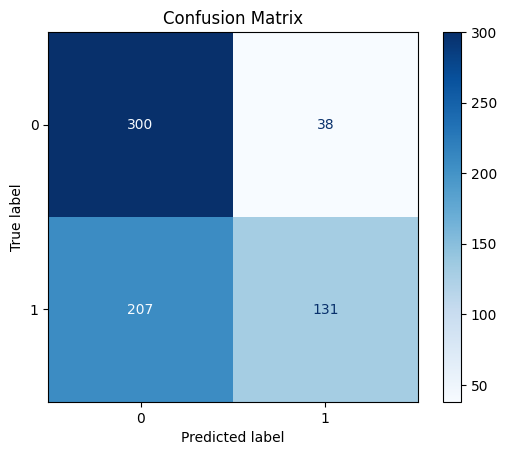

In [35]:
# Gerar a matriz de confusão
plot_confusion_matrix(y_test, y_pred)

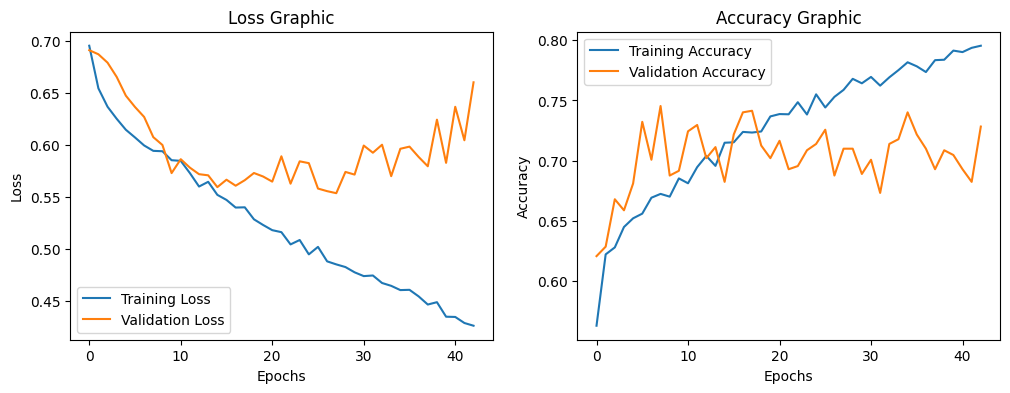

In [36]:
# Plotar o histórico do treinamento
plot_training_history(history)

In [ ]:
# Função para plotar e salvar as imagens com legenda no PDF
def plot_images_to_pdf(X_test_left, X_test_right, y_test, pdf_path='Pdf/Pacientes_Conjunto_Teste.pdf'):
    # Abre o arquivo PDF para escrita
    with PdfPages(pdf_path) as pdf:
        for i in range(len(y_test)):
            # Exibe progresso
            print(f"Processando imagem {i + 1} de {len(y_pred)}")

            # Configuração da figura
            fig, axs = plt.subplots(1, 2, figsize=(4, 4))
            fig.suptitle(f'Label Pred.: {"Sim" if y_pred[i] == 1 else "Não"}  -  Label Verd.: {"Sim" if y_test[i] == 1 else "Não"}')

            # Exibe as imagens
            axs[0].imshow(X_test_left[i], cmap='gray')
            axs[0].set_title('MRI Esquerda')
            axs[0].axis('off')

            axs[1].imshow(X_test_right[i], cmap='gray')
            axs[1].set_title('MRI Direita')
            axs[1].axis('off')

            # Adiciona a figura atual ao PDF
            pdf.savefig(fig)
            plt.close(fig)

    print(f"As imagens foram salvas no arquivo PDF '{pdf_path}' com sucesso.")

# Chame a função com seus dados
plot_images_to_pdf(X_test_left, X_test_right, y_test)

Processando imagem 1 de 676
Processando imagem 2 de 676
Processando imagem 3 de 676
Processando imagem 4 de 676
Processando imagem 5 de 676
Processando imagem 6 de 676
Processando imagem 7 de 676
Processando imagem 8 de 676
Processando imagem 9 de 676
Processando imagem 10 de 676
Processando imagem 11 de 676
Processando imagem 12 de 676
Processando imagem 13 de 676
Processando imagem 14 de 676
Processando imagem 15 de 676
Processando imagem 16 de 676
Processando imagem 17 de 676
Processando imagem 18 de 676
Processando imagem 19 de 676
Processando imagem 20 de 676
Processando imagem 21 de 676
Processando imagem 22 de 676
Processando imagem 23 de 676
Processando imagem 24 de 676
Processando imagem 25 de 676
Processando imagem 26 de 676
Processando imagem 27 de 676
Processando imagem 28 de 676
Processando imagem 29 de 676
Processando imagem 30 de 676
Processando imagem 31 de 676
Processando imagem 32 de 676
Processando imagem 33 de 676
Processando imagem 34 de 676
Processando imagem 35 d